In [14]:
import os
import math
import glob
import numpy as np
from PIL import Image
from matplotlib import image
from matplotlib import pyplot as plt
import HW2_HoughTransform as hw2

# parameters
datadir = './data'
resultdir = './results'
eps = np.finfo(float).eps

# you can calibrate these parameters
highThreshold=0.4
lowThreshold=0.1
nLines=20

sigma=2
rhoRes=2
thetaRes=math.pi/180

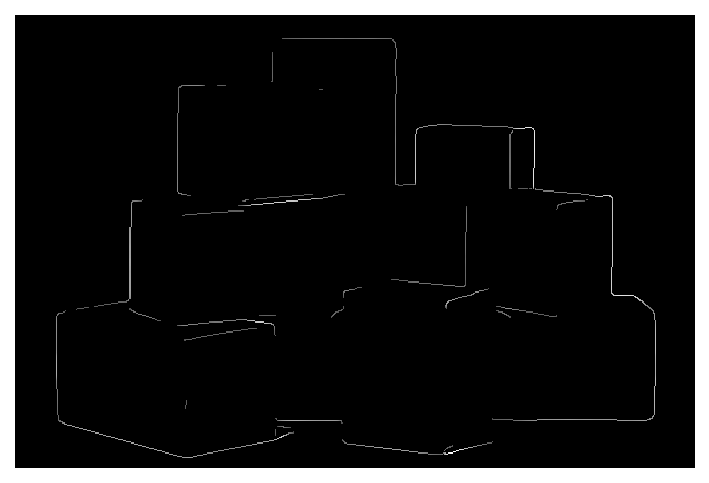

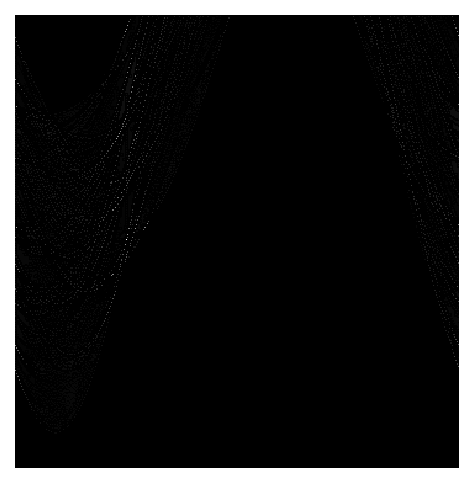

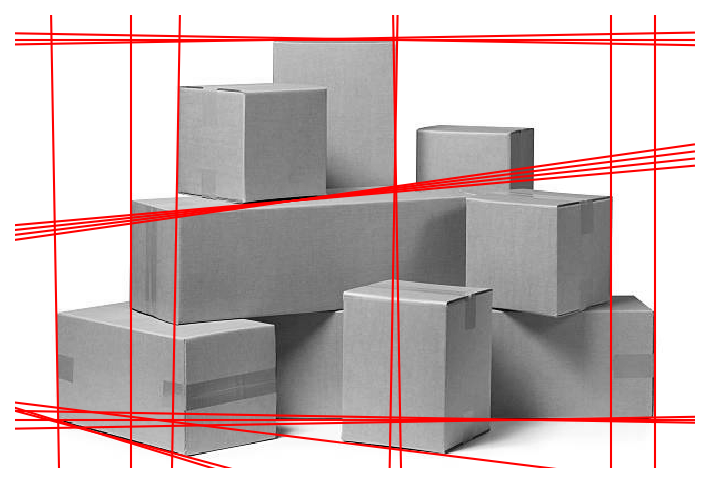

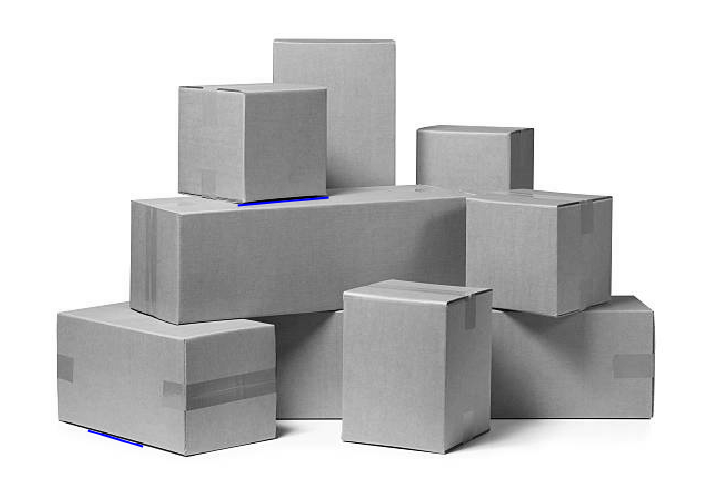

In [18]:
img_path = './data/img01.jpg'
basename = os.path.basename(img_path).split('.')[0]

# load grayscale image
img = Image.open(img_path).convert("L")
Igs = np.array(img)
Igs = Igs / 255.

# Hough function
Im, Io, Ix, Iy = hw2.EdgeDetection(Igs, sigma, highThreshold, lowThreshold)
H = hw2.HoughTransform(Im, rhoRes, thetaRes)
lRho, lTheta = hw2.HoughLines(H, rhoRes, thetaRes, nLines)
l = hw2.HoughLineSegments(lRho, lTheta, Im)

# saves the outputs to files
# Im, H, Im + hough line , Im + hough line segments
hw2.PlotImage(Im, os.path.join(resultdir, basename+"_Im.png"))
hw2.PlotImage(H, os.path.join(resultdir, basename+"_H.png"))
hw2.PlotLines(Igs, os.path.join(resultdir, basename+"_lines.png"), lTheta, lRho)
hw2.PlotSegments(Igs, os.path.join(resultdir, basename+"_segments.png"), l)

In [20]:
Igs = []
for img_path in glob.glob(datadir + '/*.jpg'):
    # load grayscale image
    img = Image.open(img_path).convert("L")
    Igs.append(np.array(img) / 255.)

In [21]:
def ConvFilter(Igs, G):
    for s in G.shape:
        if s % 2 == 0:
            raise Exception("filter size must be odd for convolution")
            
    h, w = G.shape
    image = np.pad(Igs, (h//2, w//2), mode='edge')
    
    Iconv = []
    for i in range(Igs.shape[0]):
        for j in range(Igs.shape[1]):
            Iconv.append(np.sum(image[i:i+h, j:j+w]*G))

    Iconv = np.array(Iconv).reshape(Igs.shape)
    return Iconv

(-0.5, 611.5, 407.5, -0.5)

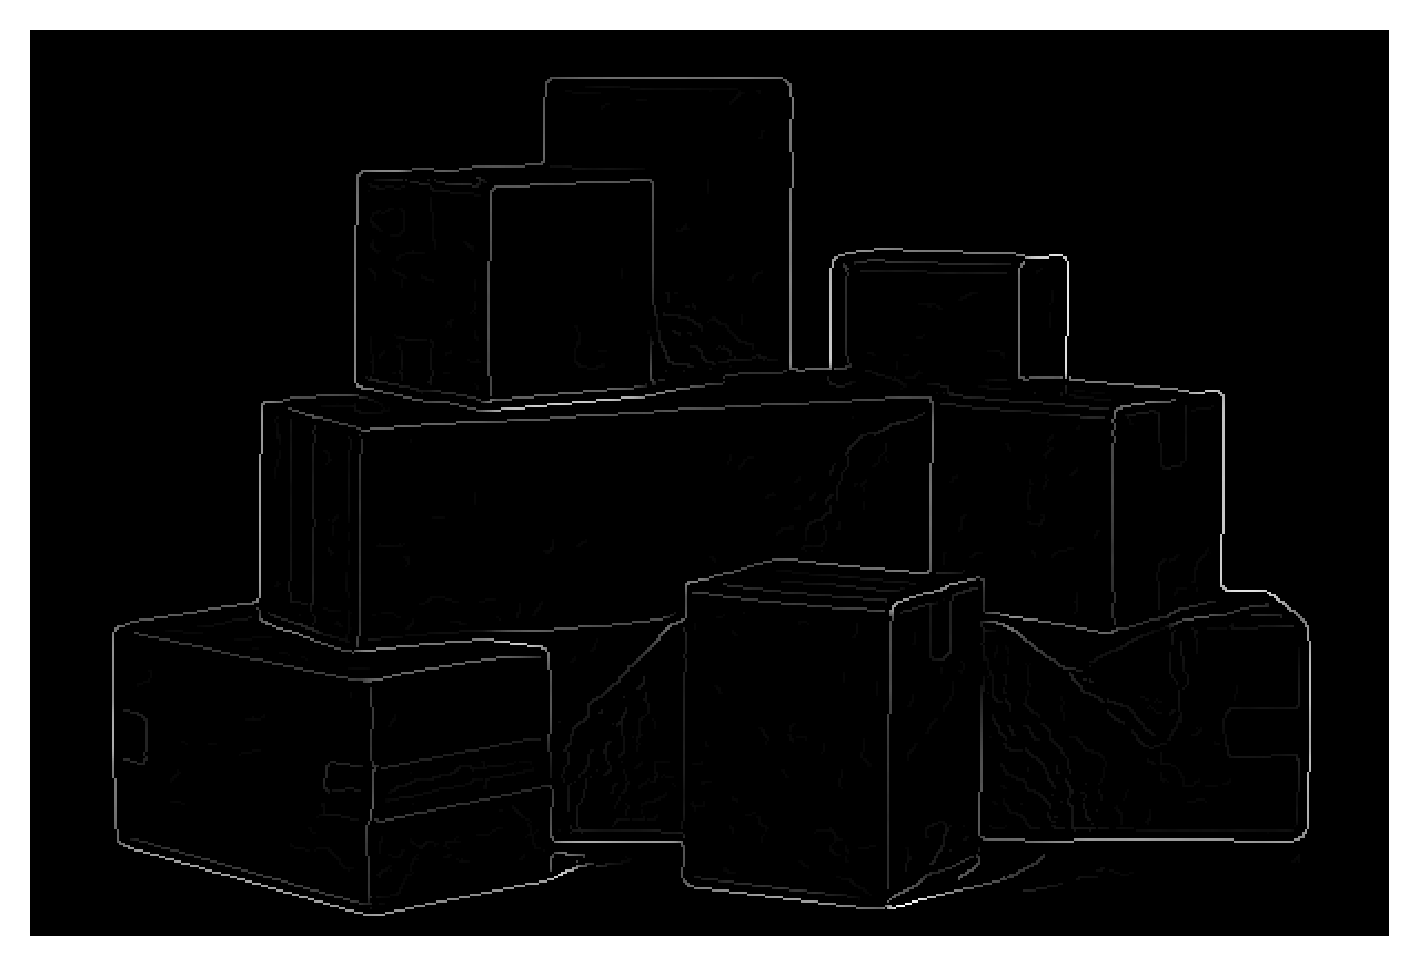

In [26]:
def EdgeDetection(Igs, sigma, highThreshold, lowThreshold):
    
    def GaussianFilter(sigma):
        size = 2 * math.ceil(3 * sigma) + 1
        xs = np.linspace(-(size//2), (size//2), size)
        Gaussian1D = np.exp((xs ** 2) / (-2 * (sigma ** 2)))
        Gaussian1D = Gaussian1D / np.sum(Gaussian1D)
        return np.outer(Gaussian1D, Gaussian1D)
    
    def NonMaximalSuppresion(Im, Io):
        Inms = np.zeros(Im.shape, dtype=np.float)
        Io[Io < 0] += np.pi

        for i in range(1, Im.shape[0]-1):
            for j in range(1, Im.shape[1]-1):
                neighbors = (1, 1)
                if   (np.pi*0/8 <= Io[i, j] < np.pi*1/8): neighbors = (Im[  i, j+1], Im[  i, j-1])
                elif (np.pi*1/8 <= Io[i, j] < np.pi*3/8): neighbors = (Im[i+1, j-1], Im[i-1, j+1])
                elif (np.pi*3/8 <= Io[i, j] < np.pi*5/8): neighbors = (Im[i+1,   j], Im[i-1,   j])
                elif (np.pi*5/8 <= Io[i, j] < np.pi*7/8): neighbors = (Im[i-1, j-1], Im[i+1, j+1])
                elif (np.pi*7/8 <= Io[i, j] < np.pi*8/8): neighbors = (Im[  i, j+1], Im[  i, j-1])

                if (Im[i,j] >= neighbors[0]) and (Im[i,j] >= neighbors[1]):
                    Inms[i,j] = Im[i,j]
        return Inms
    
    G = GaussianFilter(sigma)
    image = ConvFilter(Igs, G)
    
    sobel = [np.array([[-1, 0, 1],
                       [-2, 0, 2],
                       [-1, 0, 1]]),
             np.array([[ 1, 2, 1],
                       [ 0, 0, 0],
                       [-1,-2,-1]])]
    
    Ix = ConvFilter(image, sobel[0])
    Iy = ConvFilter(image, sobel[1])
    Io = np.arctan2(Iy, Ix)
    
    Im = NonMaximalSuppresion(np.hypot(Iy, Ix), Io)
    I = np.pad(Im, 1, mode='edge')
    
    for i in range(Im.shape[0]):
        for j in range(Im.shape[1]):
            if (lowThreshold <= I[i+1, j+1] < highThreshold):
                if not np.any(I[i:i+3, j:j+3] >= highThreshold):
                    Im[i, j] = 0
            elif I[i+1, j+1] < lowThreshold:
                Im[i, j] = 0
    
    return Im, Io, Ix, Iy

highThreshold=0.03
lowThreshold=0.01
Im, Io, Ix, Iy = EdgeDetection(Igs[0], sigma, highThreshold, lowThreshold)

plt.figure(dpi=300)
plt.imshow(Im, cmap='gray')
plt.axis('off')


(-0.5, 359.5, 319.5, -0.5)

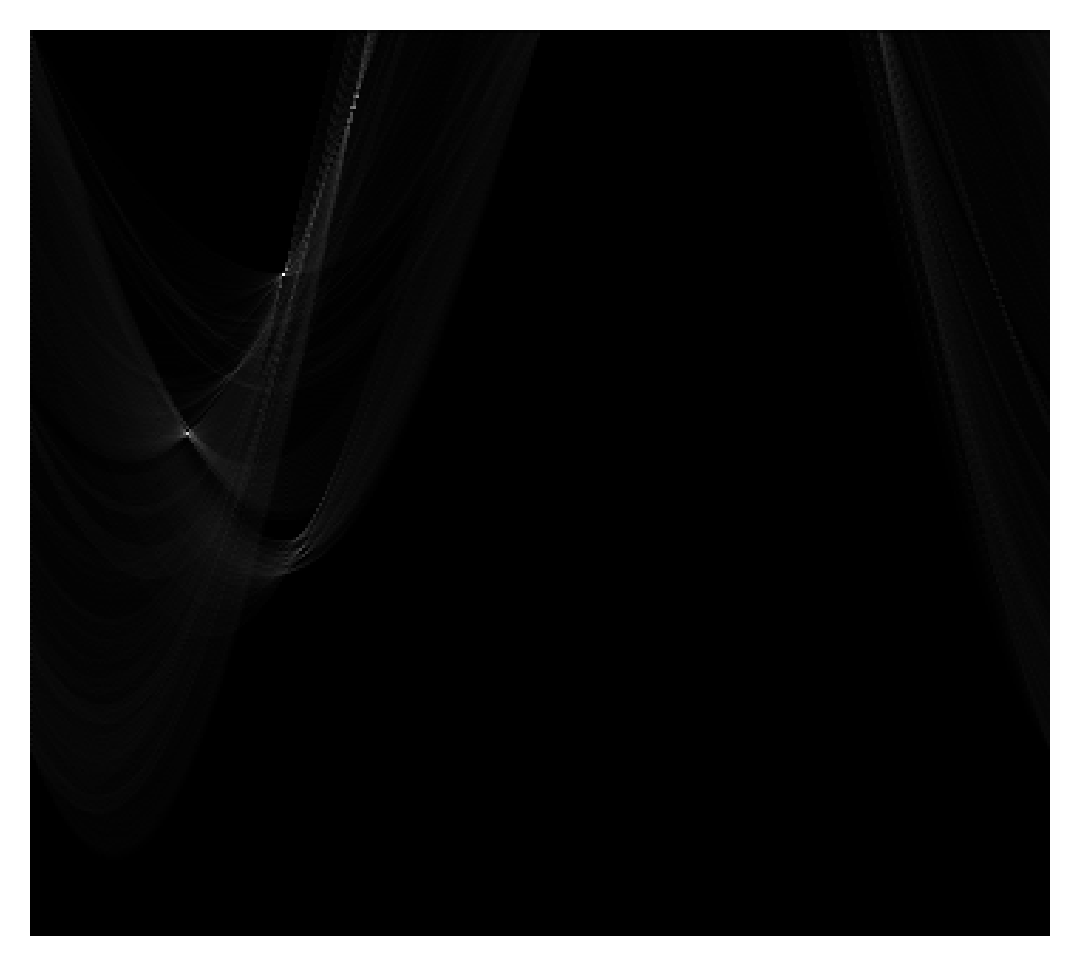

In [5]:
def HoughTransform(Im, rhoRes, thetaRes):
    r = int(np.ceil(np.linalg.norm(Im.shape) / rhoRes))
    t = int(np.ceil(2*np.pi / thetaRes))
    
    H = np.zeros((r, t), dtype=int)
    
    ts = np.arange(t) * thetaRes
    for i in range(Im.shape[0]):
        for j in range(Im.shape[1]):
            if Im[i, j] != 0:
                rho = j*np.cos(ts) + i*np.sin(ts)
                k = np.around(np.maximum(rho, 0) / rhoRes).astype(int)
                H[k, np.arange(t)] += (rho >= 0)
    
    return H

H = HoughTransform(Im, rhoRes, thetaRes)

plt.figure(dpi=300)
plt.imshow(H, cmap='gray')
plt.axis('off')

In [6]:
def HoughLines(H, rhoRes, thetaRes, nLines):
    h, w = (3, 3)
    I = np.pad(H, (h//2, w//2), 'edge')
    
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            if (np.max(I[i:i+h, j:j+w]) != I[i+h//2, j+w//2]):
                H[i, j] = 0
                
    n_index = np.argpartition(H, -nLines, None)[-nLines:]
    lRho   = rhoRes   * (n_index // H.shape[1])
    lTheta = thetaRes * (n_index %  H.shape[1])
    return lRho, lTheta

lRho, lTheta = HoughLines(H, rhoRes, thetaRes, nLines)

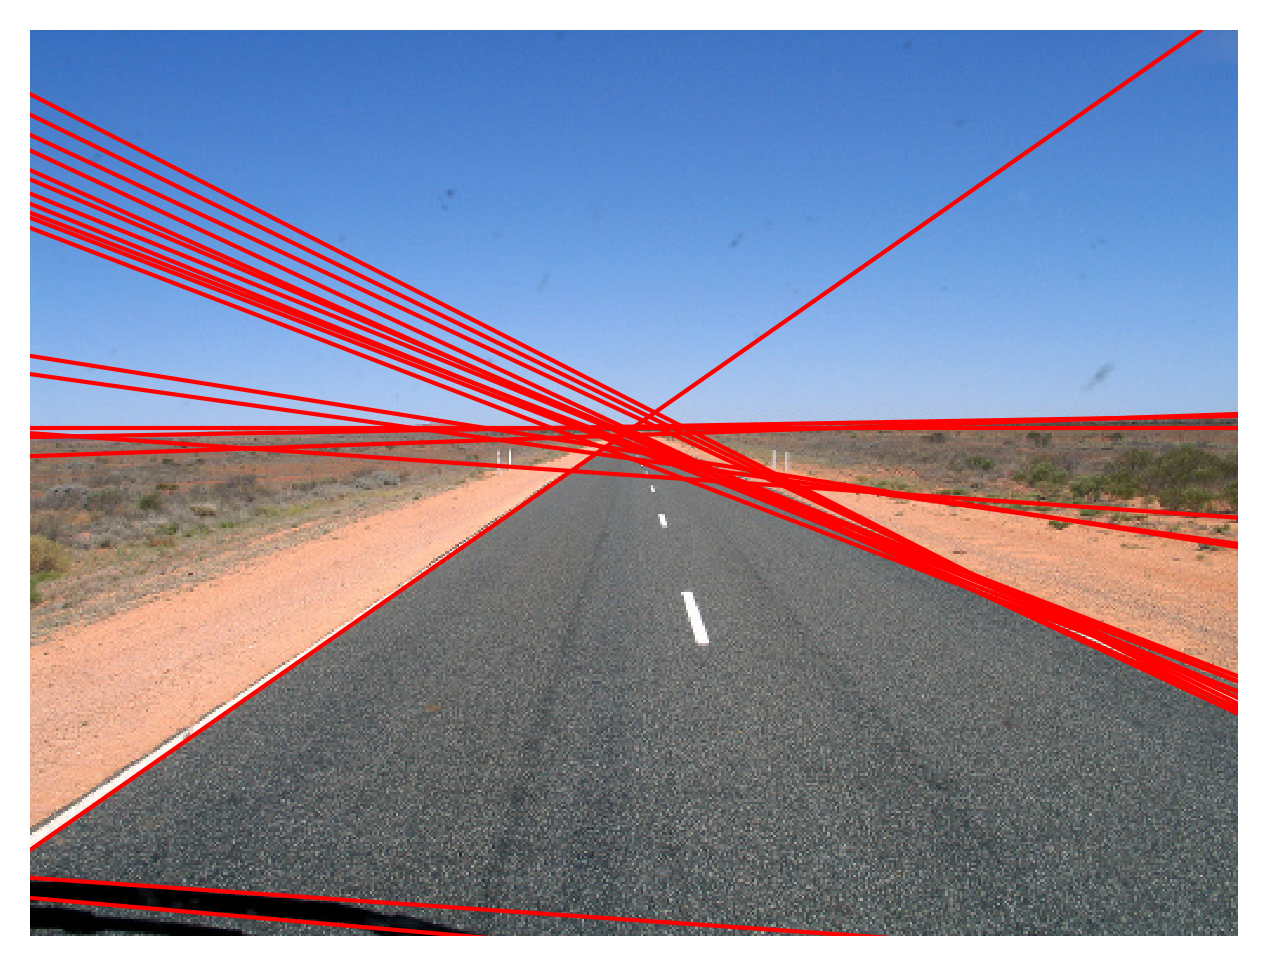

In [7]:
from matplotlib import image
import os

def PlotLines(img, name, lTheta, lRho):
    plt.figure(dpi=300)
    for theta, rho in zip(lTheta, lRho):
        if ((np.pi*0/4 <= theta < np.pi*1/4) or 
            (np.pi*3/4 <= theta < np.pi*5/4) or 
            (np.pi*7/4 <= theta < np.pi*8/4)):
            y = (0, img.shape[0]-1)
            x = ((-y[0] * np.sin(theta) + rho) / (np.cos(theta) + eps),
                 (-y[1] * np.sin(theta) + rho) / (np.cos(theta) + eps))
        else:
            x = (0, img.shape[1]-1)
            y = ((-x[0] * np.cos(theta) + rho) / (np.sin(theta) + eps),
                 (-x[1] * np.cos(theta) + rho) / (np.sin(theta) + eps))
        plt.plot(x, y, color="red", linewidth=1)

    plt.imshow(img)
    plt.axis('off')
    plt.savefig(name, bbox_inches='tight', pad_inches=0)
    

def PlotSegments(img, name, l):
    plt.figure(dpi=300)
    for xy_dict in l:
        x = (xy_dict["start"][0], xy_dict["end"][0])
        y = (xy_dict["start"][1], xy_dict["end"][1])
        plt.plot(x, y, color="blue", linewidth=1)

    plt.imshow(img)
    plt.axis('off')
    plt.savefig(name, bbox_inches='tight', pad_inches=0)

PlotLines(image.imread('./data/img02.jpg'), os.path.join(resultdir, "test.jpg"), lTheta, lRho)

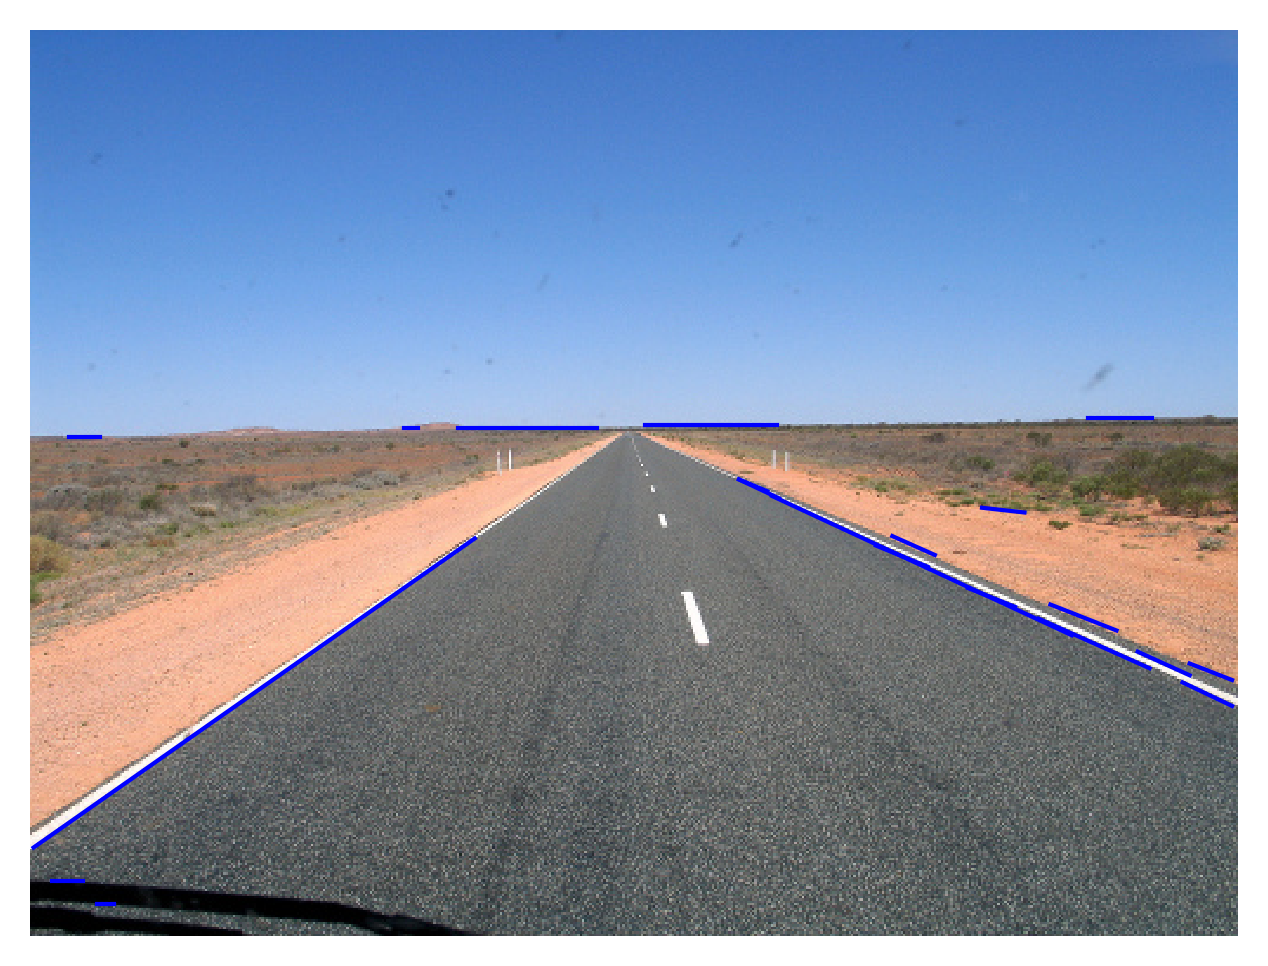

In [109]:

def HoughLineSegments(lRho, lTheta, Im):
    h, w = Im.shape
    x = np.arange(w)
    y = np.arange(h)
    l = []
    
    for theta, rho in zip(lTheta, lRho):
        l_dict = {}
        
        if ((np.pi*0/4 <= theta < np.pi*1/4) or 
            (np.pi*3/4 <= theta < np.pi*5/4) or 
            (np.pi*7/4 <= theta < np.pi*8/4)):
            x = np.around((-y * np.sin(theta) + rho)/(np.cos(theta) + eps)).astype(int)
            mask = ((x >= 0) & (x <= w-1))
        else:
            y = np.around((-x * np.cos(theta) + rho)/(np.sin(theta) + eps)).astype(int)
            mask = ((y >= 0) & (y <= h-1))
        
        x = np.clip(x, 0, w-1)
        y = np.clip(y, 0, h-1)
        
        flag = (Im[y, x] * mask) > 0
        neighbors = np.concatenate(([flag[0]], flag[:-1] != flag[1:]))
        index = np.nonzero(neighbors)[0]
        lengths = np.diff(index)

        start = index[0]
        length = lengths[0]
        cur_ind = end = start+length-1

        for i in range(len(lengths) // 2):
            leng1 = lengths[i*2+1]
            leng2 = lengths[i*2+2]
            cur_ind += leng1+leng2

            if length > 5*(leng1+leng2):
                length += leng1+leng2
            else:
                length = leng2

            if end-start+1 < length:
                start = cur_ind-length+1
                end = cur_ind
        
        l_dict["start"] = (x[start], y[start])
        l_dict["end"]   = (x[end]  , y[end])
        l.append(l_dict)
    return l
    
l = HoughLineSegments(lRho, lTheta, Im)
PlotSegments(image.imread('./data/img02.jpg'), os.path.join(resultdir, "test1.jpg"), l)